In [5]:
import sys
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

%matplotlib inline
print(f"Python version: {sys.version}\nNumpy version: {np.__version__}\nMatplotlib version: {matplotlib.__version__}\nPyTorch version: {torch.__version__}")

Python version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
Numpy version: 1.26.4
Matplotlib version: 3.8.0
PyTorch version: 2.3.0


# Problem 3

In [6]:
MNIST_DATA_PATH = "/Users/lucah/Library/CloudStorage/OneDrive-DurhamUniversity/Course Material & Work/SNU Year Abroad {SNU}/2-Spring Semester/Mathematical Foundations of Deep Neural Networks {MFDNN}/Lectures Slides {MFDNN}/Notebooks {MFDNN}/mnist_data"
NICE_MODEL_PATH = "/Users/lucah/Library/CloudStorage/OneDrive-DurhamUniversity/Course Material & Work/SNU Year Abroad {SNU}/2-Spring Semester/Mathematical Foundations of Deep Neural Networks {MFDNN}/Homeworks {MFDNN}/nice.pt"
DEVICE_CHOICE = "cpu"

## Setup (given)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt

batch_size = 128
(full_dim, mid_dim, hidden) = (1 * 28 * 28, 1000, 5)
lr = 1e-3
epochs = 100
device = torch.device(DEVICE_CHOICE)

############################################
# STEP 1: Define dataset and preprocessing #
############################################


class Logistic(torch.distributions.Distribution):
    def __init__(self):
        super(Logistic, self).__init__()

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        z = torch.distributions.Uniform(0., 1.).sample(size).to(device)
        return torch.log(z) - torch.log(1. - z)

####################################
# STEP 3: Implement Coupling Layer #
####################################

class Coupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, hidden, mask_config):
        super(Coupling, self).__init__()
        self.mask_config = mask_config

        self.in_block = nn.Sequential(nn.Linear(in_out_dim//2, mid_dim), nn.ReLU())
        self.mid_block = nn.ModuleList([nn.Sequential(nn.Linear(mid_dim, mid_dim), nn.ReLU())
                                        for _ in range(hidden - 1)])
        self.out_block = nn.Linear(mid_dim, in_out_dim//2)

    def forward(self, x, reverse=False):
        [B, W] = list(x.size())
        x = x.reshape((B, W//2, 2))
        if self.mask_config:
            on, off = x[:, :, 0], x[:, :, 1]
        else:
            off, on = x[:, :, 0], x[:, :, 1]

        off_ = self.in_block(off)
        for i in range(len(self.mid_block)):
            off_ = self.mid_block[i](off_)
        shift = self.out_block(off_)

        if reverse:
            on = on - shift
        else:
            on = on + shift

        if self.mask_config:
            x = torch.stack((on, off), dim=2)
        else:
            x = torch.stack((off, on), dim=2)
        return x.reshape((B, W))

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J

##########################
# STEP 4: Implement NICE #
##########################

class NICE(nn.Module):
    def __init__(self,in_out_dim, mid_dim, hidden, mask_config=1.0, coupling=4):
        super(NICE, self).__init__()
        self.prior = Logistic()
        self.in_out_dim = in_out_dim

        self.coupling = nn.ModuleList([
            Coupling(in_out_dim=in_out_dim,
                     mid_dim=mid_dim,
                     hidden=hidden,
                     mask_config=(mask_config+i)%2) \
            for i in range(coupling)])

        self.scaling = Scaling(in_out_dim)

    def g(self, z):
        x, _ = self.scaling(z, reverse=True)
        for i in reversed(range(len(self.coupling))):
            x = self.coupling[i](x, reverse=True)
        return x

    def f(self, x):
        for i in range(len(self.coupling)):
            x = self.coupling[i](x)
        z, log_det_J = self.scaling(x)
        return z, log_det_J

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        log_ll = torch.sum(self.prior.log_prob(z), dim=1)
        return log_ll + log_det_J

    def sample(self, size):
        z = self.prior.sample((size, self.in_out_dim)).to(device)
        return self.g(z)

    def forward(self, x):
        return self.log_prob(x)

/opt/anaconda3/envs/MFDNN/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/MFDNN/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/MFDNN/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E6933B13-F4A0-3821-8466-03F22A3B3739> /opt/anaconda3/envs/MFDNN/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Load model, show image and corrupt (given)

/opt/anaconda3/envs/MFDNN/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.Logistic'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


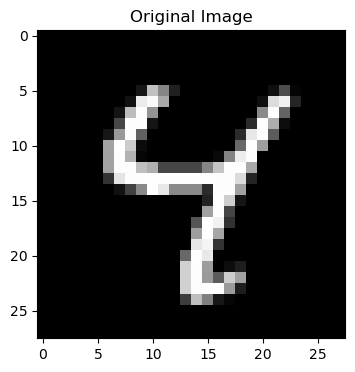

In [8]:
# Load pre-trained NICE model onto CPU
model = NICE(in_out_dim=784, mid_dim=1000, hidden=5).to(device)
model.load_state_dict(torch.load(NICE_MODEL_PATH, map_location=torch.device(DEVICE_CHOICE)))

# Since we do not update model, set requires_grad = False
model.requires_grad_(False)

# Get an MNIST image
testset = torchvision.datasets.MNIST(root=MNIST_DATA_PATH, train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
pass_count = 6
itr = iter(test_loader)
for _ in range(pass_count+1):
    image,_ = next(itr)

plt.figure(figsize = (4,4))
plt.title('Original Image')
plt.imshow(make_grid(image.squeeze().detach()).permute(1,2,0))
plt.show()
# plt.savefig('plt1.png')

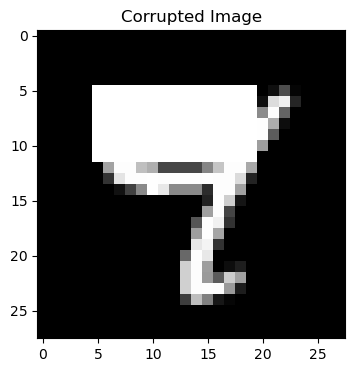

In [9]:
# Create mask 
mask = torch.ones_like(image,dtype=torch.bool)
mask[:,:,5:12,5:20] = 0

# Partially corrupt the image
masked_image = image.clone()
masked_image[mask.logical_not()] = torch.ones_like(image[mask.logical_not()])
plt.figure(figsize = (4,4))
plt.title('Corrupted Image')
plt.imshow(make_grid(masked_image.squeeze()).permute(1,2,0))
plt.show()
# plt.savefig('plt2.png')

## Reconstruct the image (task)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


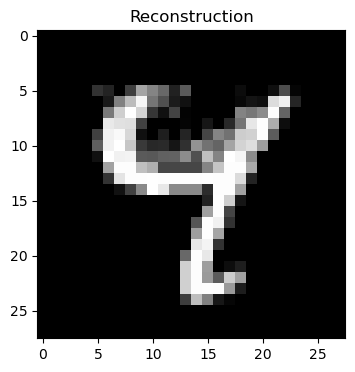

In [10]:
lr = 1e-3
X = masked_image.clone().requires_grad_(True)

def project(T: torch.Tensor):
    # enforce that region outside corrupted area is left unchanged
    T.data[mask] = image.data[mask]
    # enforce 0<=T<=1 elementwise constraint
    T.data.clamp(0, 1)

optimizer = torch.optim.SGD([X], lr=lr)
for i in range(300):
    optimizer.zero_grad()
    loss = -model(X.view(1, -1))  # forward evaluation of model is log_prob()
    loss.backward()
    optimizer.step()
    
    project(X)  # projected gradient descent (i.e. enforce constraints on optimisation of X)
    
recon = X
# Plot reconstruction
plt.figure(figsize = (4,4))
plt.title('Reconstruction')
plt.imshow(make_grid(recon.squeeze().detach()).permute(1,2,0))
plt.show()
# plt.savefig('plt3.png')

## Comparison plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


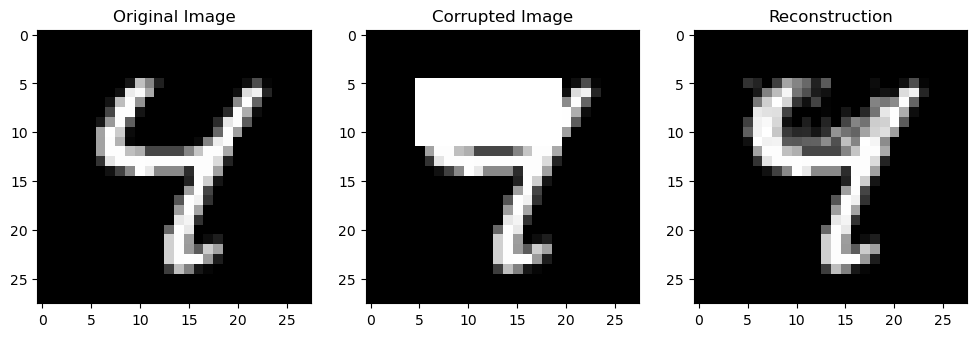

In [11]:
# Plot all three images side by side
def imshow_prep(im):
    return make_grid(im.squeeze().detach()).permute(1,2,0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.set_title('Original Image')
ax1.imshow(imshow_prep(image))
ax2.set_title('Corrupted Image')
ax2.imshow(imshow_prep(masked_image))
ax3.set_title('Reconstruction')
ax3.imshow(imshow_prep(recon))
plt.show()

# Problem 5

In [20]:
import torch

torch.random.manual_seed(42)

N = 3000  # num samples
K = 600   # num games per sample

p = 18/37 # probability of winning (regular)
q = 0.55  # probability of winning *in importance/sampling distribution*

def pdf(prob, Xis):
    return (torch.pow(prob, Xis) * torch.pow(1-prob, 1-Xis)).prod(dim=1, dtype=torch.float64)

games = torch.distributions.Bernoulli(probs=q).sample((N, K))

# naive count which could go negative and go back up (ihat=1.1133789065043346e-06)
# num_wins = games.sum(dim=1)
# balances = 100 - K + 2*num_wins

# play out each game (ihat=2.3209170497269283e-06)
# balances = torch.zeros(N)
# for si, sample in enumerate(games):
#     sample_balance = 100  # starting balance
#     for game in sample:
#         sample_balance += 2*game - 1  # costs $1 and if win (game==1) get $2
#         if sample_balance < 0:
#             break
#         elif sample_balance >= 200:  # stop if balance reaches $200
#             balance[si] = 200
#             break

# play out each game (vectorised) (ihat=2.009666286616056e-06)
game_diffs = 2*games - 1 # convert 0/1 to -1/1 to track winnings/cost
running_balances = 100 + game_diffs.cumsum(dim=1)
# set all values after a 0 to 0 (since player quits at $0)
if (running_balances==0).any():
    running_balances[(running_balances==0).nonzero(as_tuple=True)[0].item() + 1:] = 0
balances = running_balances.max(dim=1).values  # if 200 crossed, will be the maximum

f = pdf(p, games)
g = pdf(q, games)
samp = ((balances>=200)*f/g)

ihat = samp.mean()
print(ihat.item())

2.805462322717998e-06


In [21]:
# from solutions
from tqdm import tqdm
import numpy as np

np.random.seed(42)

p =  18/37
q = 0.55
K = 600
upper_bound = 200
lower_bound = 0
N = 3000

count = 0
sum = 0

for i in tqdm(range(N)):
    money = 100  # initialize money
    total = 1  # initialize total
    win = None
    for i in range(K):
        u = np.random.uniform(low=0., high=1., size=(1))
        if u < q:
            money += 1
            total *= p/q
        else:
            money -= 1
            total *= (1-p)/(1-q)

        if money == upper_bound or money == lower_bound:
            if win == None:
                if money == upper_bound:
                    win = True
                else:
                    win = False

    if win == True:
        sum += total

print('approximated probability: ', sum/N)

100%|██████████| 3000/3000 [00:03<00:00, 937.26it/s]

approximated probability:  2.158274883609251e-06


# Problem 6

In [14]:
def plot_sgd_path(history, ax=None):
    mu = np.array(history[:, 0])
    sigma = np.array(history[:, 1])
    if ax is not None:
        p = ax
    else:
        p = plt
    
    p.plot(mu, sigma, linestyle='solid', color='blue', zorder=0)
    p.grid(True, which='both', linestyle='--')
    
    # show labels next to start and end scatter points
    p.scatter(mu[0], sigma[0], color='blue', label='Initial', zorder=1)
    p.text(mu[0], sigma[0], 'Start', verticalalignment='bottom', horizontalalignment='right', c='blue', zorder=1)
    p.scatter(mu[-1], sigma[-1], color='red', label='Final', zorder=1)
    p.text(mu[-1], sigma[-1], 'End', verticalalignment='bottom', horizontalalignment='right', c='red', zorder=1)
    
    # label axes
    plt.xlabel('$\mu$')
    plt.ylabel(r'$\tau$')

In [15]:
def evaluate(mu, tau, samples=5000):
    sigma = torch.exp(tau)
    X = torch.normal(mu, sigma, size=(samples,))
    return ((X*torch.sin(X)).sum() + 0.5 * (mu - 1)**2 + sigma - torch.log(sigma)).item()

In [16]:
lr = 1e-2
B = 16
iterations = 1500

## Part (a): log-derivative trick

Optimal mu: 0.437
Optimal sigma (tau): 0.616 (-0.485)


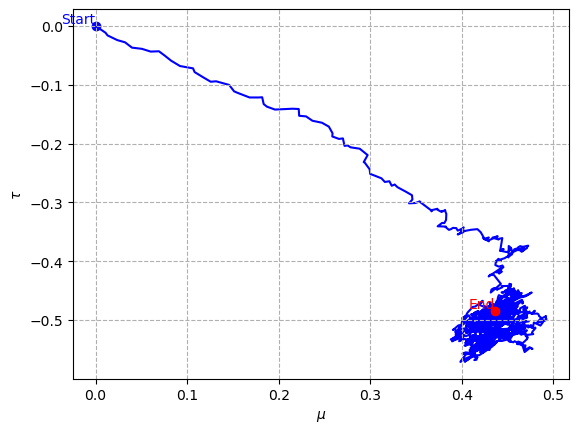

In [17]:
torch.manual_seed(42)
mu = torch.zeros(1)
tau = torch.zeros(1)
history1 = torch.zeros((iterations+1, 2))

for itr in range(iterations):
    history1[itr] = torch.tensor([mu, tau])
    
    X = torch.normal(mu.item(), torch.exp(tau).item(), size=(B,))
    
    # SGD update
    grad_mu = (X * torch.sin(X) * (X - mu)/torch.exp(2*tau)).mean() + mu - 1
    # previously mistakenly used: torch.exp(2*tau + 1)
    grad_tau = (X * torch.sin(X) * (torch.pow(X - mu, 2)/torch.exp(2*tau) - 1)).mean() + torch.exp(tau) - 1
    
    mu -= lr * grad_mu
    tau -= lr * grad_tau
    
history1[-1] = torch.tensor([mu, tau])

print(f"Optimal mu: {mu.item():.3f}\nOptimal sigma (tau): {torch.exp(tau).item():.3f} ({tau.item():.3f})")
plot_sgd_path(history1)

## Part (b): reparameterisation trick

Optimal mu: 0.440
Optimal sigma (tau): 0.602 (-0.507)


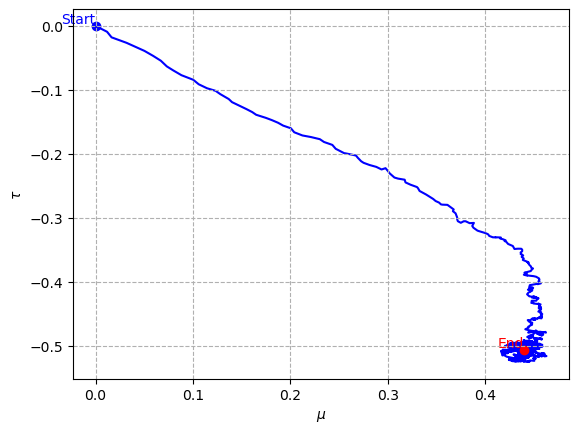

In [18]:
torch.manual_seed(42)
mu = torch.zeros(1)
tau = torch.zeros(1)
history2 = torch.zeros((iterations+1, 2))

for itr in range(iterations):
    history2[itr] = torch.tensor([mu, tau])
    
    Y = torch.normal(0, 1, size=(B,))

    # SGD update
    sigma = torch.exp(tau)
    Z = mu + sigma*Y
    
    grad_mu = (torch.sin(Z) + Z*torch.cos(Z)).mean() + mu - 1
    grad_tau = (sigma*Y*torch.sin(Z) + Z*sigma*Y*torch.cos(Z)).mean() + torch.exp(tau) - 1

    mu -= lr * grad_mu
    tau -= lr * grad_tau
    
history2[-1] = torch.tensor([mu, tau])

print(f"Optimal mu: {mu.item():.3f}\nOptimal sigma (tau): {torch.exp(tau).item():.3f} ({tau.item():.3f})")
plot_sgd_path(history2)

## Comparison plot

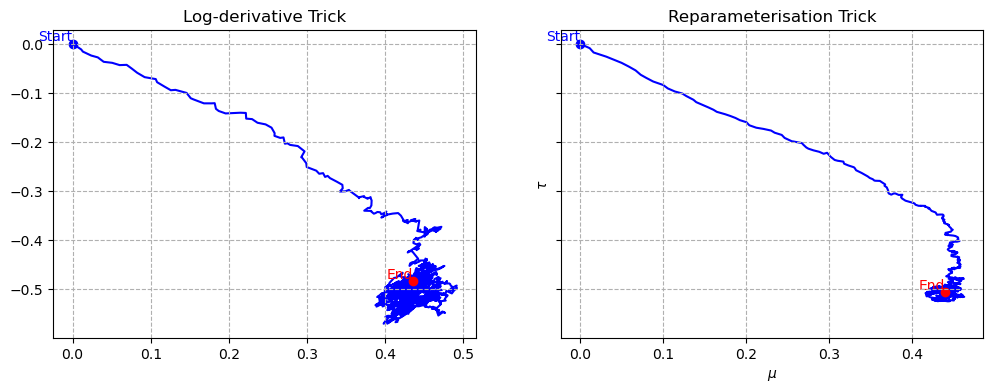

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plot_sgd_path(history1, ax1)
ax1.set_title('Log-derivative Trick')

plot_sgd_path(history2, ax2)
ax2.set_title('Reparameterisation Trick')

# plt.tight_layout()
plt.show()